<a href="https://colab.research.google.com/github/Abdulbarikassim/FaceEmotionDetection/blob/main/mobileNetV3small.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_set = '/content/drive/MyDrive/datasets/ckextended.csv'

In [5]:
import pandas as pd

df = pd.read_csv(data_set)


# Inspect the first few pixel entries
print("Sample pixel data:", df['pixels'].head())

# Check the length of pixel data for each row
df['pixel_count'] = df['pixels'].apply(lambda x: len(x.split()))
print("Pixel counts:", df['pixel_count'].describe())
print("Rows with incorrect pixel count:", df[df['pixel_count'] != 2304])

Sample pixel data: 0    36 39 35 25 19 11 8 7 3 13 15 9 21 57 75 90 10...
1    88 74 19 4 5 5 3 12 8 21 15 21 15 18 24 29 32 ...
2    9 2 4 7 1 1 1 0 7 29 49 76 115 141 156 169 177...
3    104 106 108 104 95 50 60 61 58 83 126 133 139 ...
4    68 72 67 67 6 2 1 1 1 1 1 14 24 24 38 65 79 94...
Name: pixels, dtype: object
Pixel counts: count     920.0
mean     2304.0
std         0.0
min      2304.0
25%      2304.0
50%      2304.0
75%      2304.0
max      2304.0
Name: pixel_count, dtype: float64
Rows with incorrect pixel count: Empty DataFrame
Columns: [emotion, pixels, Usage, pixel_count]
Index: []


  ### Preprocessing the data.

In [6]:
import numpy as np
import cv2
import pandas as pd

def load_ck_plus_dataset_from_csv(csv_path):
    df = pd.read_csv(csv_path)

    images = []
    labels = []

    for idx, row in df.iterrows():
        # Convert pixel string to array
        pixel_values = np.fromstring(row['pixels'], dtype=int, sep=' ')

        # Validate pixel count
        if len(pixel_values) != 2304:
            print(f"Skipping row {idx}: Invalid pixel count ({len(pixel_values)})")
            continue

        # Check for invalid pixel values
        if np.any(pixel_values < 0) or np.any(pixel_values > 255):
            print(f"Skipping row {idx}: Pixel values out of range ({pixel_values.min()}, {pixel_values.max()})")
            continue

        # Reshape to 48x48x1 and cast to uint8
        img = pixel_values.reshape(48, 48, 1).astype(np.uint8)

        # Resize and preprocess
        try:
            img = cv2.resize(img, (224, 224))
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            img = img / 255.0  # Normalize to [0,1]
            images.append(img)
            labels.append(row['emotion'])
        except Exception as e:
            print(f"Error processing row {idx}: {e}")
            continue

    return np.array(images), np.array(labels)

In [7]:

# Load the dataset
X, y = load_ck_plus_dataset_from_csv(data_set)

# Verify shapes and labels
print("Images shape:", X.shape)
print("Labels shape:", y.shape)
print("Unique emotions:", np.unique(y))

Images shape: (920, 224, 224, 3)
Labels shape: (920,)
Unique emotions: [0 1 2 3 4 5 6 7]


## Training the model

In [8]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_train = to_categorical(y_train, num_classes=8)
y_test = to_categorical(y_test, num_classes=8)


print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes:", X_test.shape, y_test.shape)

Train shapes: (736, 224, 224, 3) (736, 8)
Test shapes: (184, 224, 224, 3) (184, 8)


In [10]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Multiply

# SE (Squeeze-and-Excitation) block
def se_block(input_tensor, reduction_ratio=16):
    channels = input_tensor.shape[-1]
    # Squeeze: Global average pooling to reduce spatial dimensions to (1, 1, channels)
    se = GlobalAveragePooling2D()(input_tensor)
    # Excitation: Two dense layers to model channel-wise dependencies
    se = Dense(channels // reduction_ratio, activation='relu')(se)
    se = Dense(channels, activation='sigmoid')(se)
    # Reshape to (1, 1, channels) for broadcasting
    se = tf.keras.layers.Reshape((1, 1, channels))(se)
    # Scale the input tensor by the SE weights
    return Multiply()([input_tensor, se])

# Updated create_mobilenetv3_model with SE block and SELU
def create_mobilenetv3_model(num_classes=8):
    # Load the MobileNetV3Small base model
    base_model = MobileNetV3Small(
        input_shape=(224, 224, 3),
        weights='imagenet',
        include_top=False,
        alpha=1.0
    )
    base_model.trainable = False

    # Get the last layer's output instead of 'multiply_8'
    intermediate_layer = base_model.layers[-1].output

    # Apply the SE block to the intermediate layer
    se_output = se_block(intermediate_layer)

    # Build the model
    x = se_output

    # Add the top layers
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='selu', kernel_initializer='lecun_normal')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    # Create the final model
    model = models.Model(inputs=base_model.input, outputs=output)

    return model

# Create and compile the model
model = create_mobilenetv3_model(num_classes=8)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [11]:
#let see the model summary

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv (Conv2D)             │ (None, 112, 112, 16)   │            432 │ rescaling_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_bn                   │ (None, 112, 112, 16)   │             64 │ conv[0][0]             │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_18             │ (None, 112, 112, 16)   │              0 │ conv_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 113, 113, 16)   │              0 │ activation_18[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 56, 56, 16)     │            144 │ expanded_conv_depthwi… │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 56, 56, 16)     │             64 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_14 (ReLU)           │ (None, 56, 56, 16)     │              0 │ expanded_conv_depthwi… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 16)       │              0 │ re_lu_14[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 8)        │            136 │ expanded_conv_squeeze… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 8)        │              0 │ expanded_conv_squeeze… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_squeeze_ex… │ (None, 1, 1, 16)       │            144 │ expanded_conv_squeeze… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_9 (Add)               │ (None, 1, 1, 16)       │              0 │ expanded_conv_squeeze… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_15 (ReLU)      

 Total params: 1,056,604 (4.03 MB)

 Trainable params: 117,228 (457.92 KB)

 Non-trainable params: 939,376 (3.58 MB)

In [27]:
# Define training parameters
batch_size = 64
epochs = 50
learning_rate = 0.001

# Define the optimizer with a fixed learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Compile the model without callbacks
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model without using `data_augmentation` during fitting
history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,

)

# Print the final training accuracy
train_accuracy = history.history['accuracy'][-1]
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")


# Evaluate the model on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.4f}")

model_path = "/content/drive/MyDrive/ck_mobileNetv2.h5"
model.save(model_path)

print(f"Model saved at: {model_path}")

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 874ms/step - accuracy: 0.6323 - loss: 1.6021
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 734ms/step - accuracy: 0.7166 - loss: 1.3859
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 874ms/step - accuracy: 0.6940 - loss: 1.2470
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 866ms/step - accuracy: 0.7621 - loss: 1.0466
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 709ms/step - accuracy: 0.7688 - loss: 0.9311
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 966ms/step - accuracy: 0.7791 - loss: 0.8384
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 890ms/step - accuracy: 0.7849 - loss: 0.8088
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 826ms/step - accuracy: 0.8005 - loss: 0.7422
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 781ms/step - accuracy: 0.7883 - loss: 0.7391
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 917ms/step - accuracy: 0.7904 - loss: 0.6918
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.8013 - loss: 0.6875
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 15s 90

Test accuracy: 0.0978
Model saved at: /content/drive/MyDrive/ck_mobileNetv2.h5


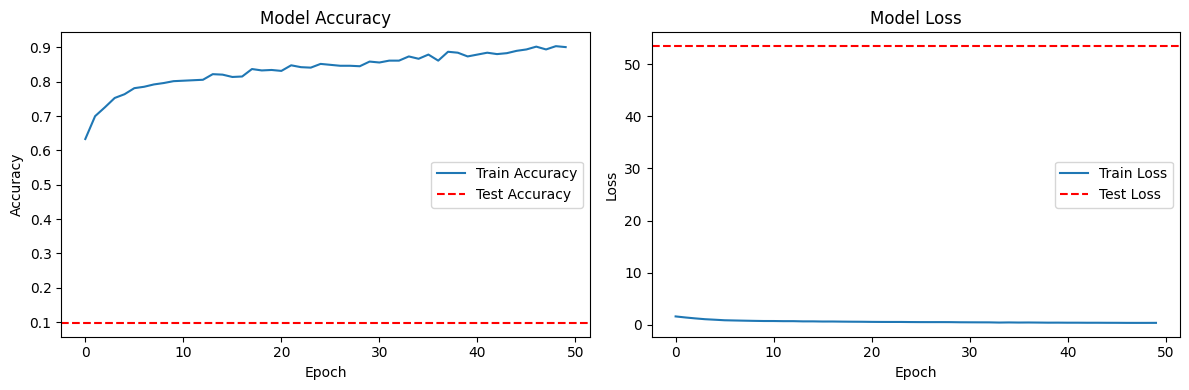

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')

plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')  # Add test accuracy as a horizontal line
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')

plt.axhline(y=test_loss, color='r', linestyle='--', label='Test Loss')  # Add test loss as a horizontal line
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
